# Information Retrieval

In [1]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm/" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

##  Indexing:

In [4]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
parser = ParserCACM.ParserCACM()
idx.indexation(cacm_txt, parser, stemmer, verbose=True)
N_docs = len(idx.getDocsID())
print("Successfully indexed %d documents" % N_docs)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.
Successfully indexed 3204 documents


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
This query has 28 relevant results
   i |found| precision | recall
    2|   1 | 0.500000  |0.035714
    4|   2 | 0.500000  |0.071429
   14|   3 | 0.214286  |0.107143
   15|   4 | 0.266667  |0.142857
   23|   5 | 0.217391  |0.178571
   25|   6 | 0.240000  |0.214286
   36|   7 | 0.194444  |0.250000
   43|   8 | 0.186047  |0.285714
   44|   9 | 0.204545  |0.321429
  127|  10 | 0.078740  |0.357143
  135|  11 | 0.081481

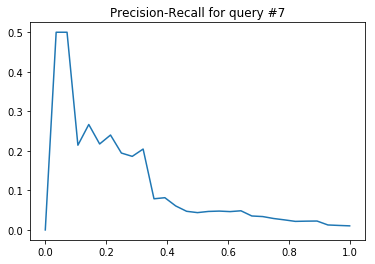

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
This query has 19 relevant results
   i |found| precision | recall
    2|   1 | 0.500000  |0.052632
    4|   2 | 0.500000  |0.105263
   22|   3 | 0.136364  |0.157895
   25|   4 | 0.160000  |0.210526
   26|   5 | 0.192308  |0.263158
   27|   6 | 0.222222  |0.315789
   34|   7 | 0.205882  |0.368421
   38|   8 | 0.210526  |0.421053
   41|   9 | 0.219512  |0.473684
  123|  10 | 0.081301  |0.526316
  126|  11 | 0.087302  |0.578947
  127|  12 | 0.094488  |0.631579
  137|  13 | 0.094891  |0.684211
  138|  14 | 0.101449  |0.736842
  139|  15 | 0.107914  |0.789474
  212|  16 | 0.075472  |0.842105
  213|  17 | 0.079812  |0.894737
  242|  18 | 0.074380  |0.947368
  382|  19 | 0.049738  |1.000000


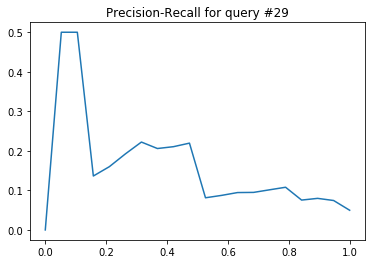

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
This query has 4 relevant results
   i |found| precision | recall
    3|   1 | 0.333333  |0.250000
    4|   2 | 0.500000  |0.500000
   37|   3 | 0.081081  |0.750000
  312|   4 | 0.012821  |1.000000


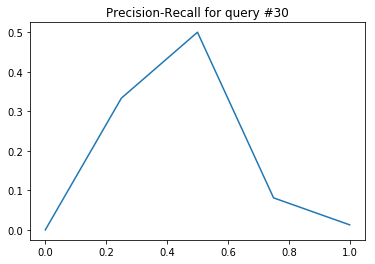

--------------------
Done.


In [5]:
binWeighter = modeles.BinaryWeighter(idx)
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


## Testing average precision:

In [6]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen =[9, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [9, 10, 14, 29] 

Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    1|   1 | 1.000000
    3|   2 | 0.666667
    8|   3 | 0.375000
   10|   4 | 0.400000
   12|   5 | 0.416667
   33|   6 | 0.181818
   62|   7 | 0.112903
  114|   8 | 0.070175
  169|   9 | 0.053254
Average precision: 0.364054
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
Evaluate the scores.
This query has 35 relevant resu

## Testing EvalIRModel:

In [7]:
print("\n###### Testing evaluation.EvalIRModel: ###### ")
queryChosen = np.random.randint(1, 64, size=10)
#queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [38 44 59  3 26  8 14 11 56 38] ...
Found queries
Calling eval()...
{('vectoriel_bw', 'averagePrecision'): (0.19078914857471294, 0.16158531936879822), ('vectoriel_tfidf', 'averagePrecision'): (0.25421049762565728, 0.16559802001058002)}
Done.


## Comparison of language models:

In [8]:
from sklearn.model_selection import train_test_split

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_train, q_test = train_test_split(queries)

# Train models, find best parameters.
unigram_params_grid = {'index':[idx], 'regularization':np.linspace(0,1, 20, endpoint=False)}

#c = dict_combinations(params_grid)
#print("comb: ",c)

best_unigram_params = {'index':idx, 'regularization':0.36842105263157893}
#best_unigram_params = evaluation.gridsearch(modeles.UnigramLanguage, unigram_params_grid, 
#                 q_train, evaluation.AveragePrecision, verbose=1)
print("Best unigram params:", best_unigram_params)

Searching for queries # [38 44 59  3 26  8 14 11 56 38] ...
Found all queries
Best unigram params: {'index': <indexation.Index object at 0x7f78244f8630>, 'regularization': 0.3684210526315789}


In [9]:
okapi_params_grid = {'index':[idx], 'k':np.linspace(1, 2, 10), 'b':np.linspace(0,2,10)}

best_okapi_params = {'index':idx, 'k': 1.1111111111111112, 'b': 0.44444444444444442}
#best_okapi_params = evaluation.gridsearch(modeles.Okapi, okapi_params_grid, 
#             q_train, evaluation.AveragePrecision, verbose=1)

print("Best okapi params:", best_okapi_params)

Best okapi params: {'index': <indexation.Index object at 0x7f78244f8630>, 'k': 1.1111111111111112, 'b': 0.4444444444444444}


### Execution on the test set:

In [10]:
print("best unigram params:", best_unigram_params)
print("best okapi params:", best_okapi_params)

irmodels = {'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)}

eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

best unigram params: {'index': <indexation.Index object at 0x7f78244f8630>, 'regularization': 0.3684210526315789}
best okapi params: {'index': <indexation.Index object at 0x7f78244f8630>, 'k': 1.1111111111111112, 'b': 0.4444444444444444}
IRModel: okapi
Measure: measure
(0.31792918023020861, 0.22842318366690459)
IRModel: unigram
Measure: measure
(0.23472680754812444, 0.17110056532188564)
{('unigram', 'measure'): (0.23472680754812444, 0.17110056532188564), ('okapi', 'measure'): (0.31792918023020861, 0.22842318366690459)}


In [11]:
print("\n###### Comparison of different models: ###### ")
queryChosen = np.random.randint(1, 64, size=5)
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter),
            'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Comparison of different models: ###### 
Searching for queries # [18 12 38 32  3 25 61 27 59 42 34  9 63 43  6 17 35 30 60  2] ...
Found queries
Calling eval()...
{('vectoriel_bw', 'averagePrecision'): (0.14577125299104834, 0.12544956712619476), ('okapi', 'averagePrecision'): (0.30850784415358301, 0.18401051756910761), ('vectoriel_tfidf', 'averagePrecision'): (0.23385479231112102, 0.16046801339477315), ('unigram', 'averagePrecision'): (0.30068116520950039, 0.1916573856833447)}
Done.


## PageRank


###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
Start the power method...
End of the power method...
This query has 28 relevant results
   i |found| precision | recall
    8|   1 | 0.125000  |0.035714
   10|   2 | 0.200000  |0.071429
   15|   3 | 0.200000  |0.107143
   20|   4 | 0.200000  |0.142857
   23|   5 | 0.217391  |0.178571
   28|   6 | 0.214286  |0.214286
   30|   7 | 0.233333  |0.250000
   38|   8 | 0.210526  |0.285714
   65|   9 | 0.138462  |0.321429
 

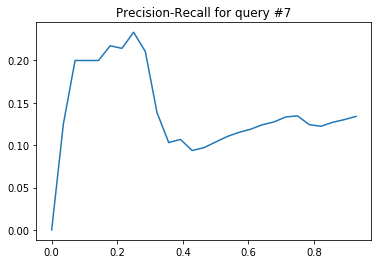

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
Start the power method...
End of the power method...
This query has 19 relevant results
   i |found| precision | recall
   10|   1 | 0.100000  |0.052632
   22|   2 | 0.090909  |0.105263
   30|   3 | 0.100000  |0.157895
   31|   4 | 0.129032  |0.210526
   37|   5 | 0.135135  |0.263158
   44|   6 | 0.136364  |0.315789
   50|   7 | 0.140000  |0.368421
   62|   8 | 0.129032  |0.421053
   63|   9 | 0.142857  |0.473684
   64|  10 | 0.156250  |0.526316
   71|  11 | 0.154930  |0.578947
   90|  12 | 0.133333  |0.631579
  102|  13 | 0.127451  |0.684211


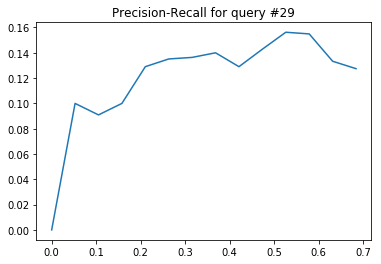

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
Start the power method...
End of the power method...
This query has 4 relevant results
   i |found| precision | recall
   25|   1 | 0.040000  |0.250000
  198|   2 | 0.010101  |0.500000


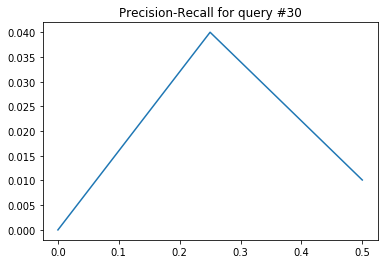

--------------------
Done.


In [48]:
pagerank_model = modeles.PageRankModel(idx, baseModel=vect, seedsNbr=20, parentsNbr=3)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = pagerank_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


In [49]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen =[9, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = pagerank_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [9, 10, 14, 29] 

Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
Start the power method...
End of the power method...
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    5|   1 | 0.200000
   18|   2 | 0.111111
   61|   3 | 0.049180
   69|   4 | 0.057971
   79|   5 | 0.063291
   82|   6 | 0.073171
   99|   6 | 0.060606
  101|   7 | 0.069307
  102|   7 | 0.068627
  104|   8 | 0.076923
  111|   9 | 0.081081
Average precision: 0.101252
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896,

In [56]:
pagerank_params_grid = {'index':[idx], 
                        'baseModel':[modeles.Vectoriel(idx, tfidfWeighter), modeles.Vectoriel(idx, binWeighter)],
                        'seedsNbr':np.logspace(1, 3, num=3, dtype=int), 
                        'parentsNbr':np.linspace(0, 100, num=3, dtype=int)}

best_pagerank_params = evaluation.gridsearch(modeles.PageRankModel, pagerank_params_grid, 
             q_train, evaluation.AveragePrecision, verbose=1)

print("Best PageRank params:", best_pagerank_params)
pagerank_model = modeles.PageRankModel(**best_pagerank_params)

Calling eval()
[  0 /  18] IRModel '0'
Measure: measure
(0.19880703801882474, 0.12182758232406332)
[  1 /  18] IRModel '1'
Measure: measure
(0.19949177231336321, 0.12253383777079788)
[  2 /  18] IRModel '2'
Measure: measure
(0.19949177231336321, 0.12253383777079788)
[  3 /  18] IRModel '3'
Measure: measure
(0.074733732932625849, 0.04523652083571332)
[  4 /  18] IRModel '4'
Measure: measure
(0.074733732932625849, 0.04523652083571332)
[  5 /  18] IRModel '5'
Measure: measure
(0.074733732932625849, 0.04523652083571332)
[  6 /  18] IRModel '6'
Measure: measure
(0.038211534527821119, 0.020938315200098877)
[  7 /  18] IRModel '7'
Measure: measure
(0.038211534527821119, 0.020938315200098877)
[  8 /  18] IRModel '8'
Measure: measure
(0.038211534527821119, 0.020938315200098877)
[  9 /  18] IRModel '9'
Measure: measure
(0.13336869429236131, 0.11284533114397692)
[ 10 /  18] IRModel '10'
Measure: measure
(0.13336869429236131, 0.11284533114397692)
[ 11 /  18] IRModel '11'
Measure: measure
(0.133368

## HITS


###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
retrieve base ranking
retrieved base ranking, call HITS
call getScores
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iterat

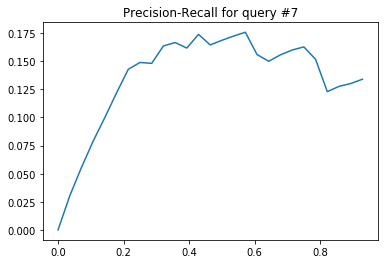

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
retrieve base ranking
retrieved base ranking, call HITS
call getScores
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48

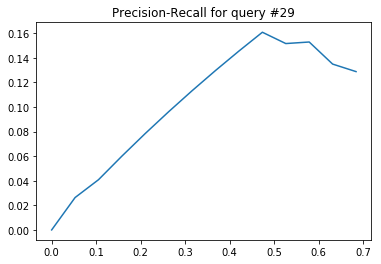

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
retrieve base ranking
retrieved base ranking, call HITS
call getScores
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteratio

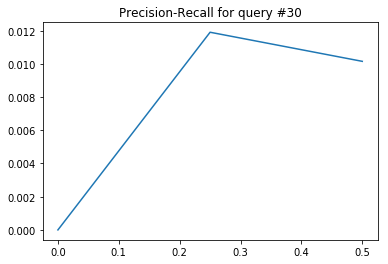

--------------------
Done.


In [63]:
hits_model = modeles.HitsModel(idx, baseModel=vect, seedsNbr=20, parentsNbr=3)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = hits_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


In [ ]:
hits_params_grid = {'index':[idx], 
                        'baseModel':[modeles.Vectoriel(idx, tfidfWeighter), modeles.Vectoriel(idx, binWeighter)],
                        'seedsNbr':[10, 20, 30], 
                        'parentsNbr':[0, 2, 10]}

best_hits_params = evaluation.gridsearch(modeles.HitsModel, hits_params_grid, 
             q_train, evaluation.AveragePrecision, verbose=1)

print("Best HITS params:", best_hits_params)
hits_model = modeles.HitsModel(**best_hits_params)

Calling eval()
[  0/ 18] IRModel '0'
100 nodes in the sub-graph
151 nodes in the sub-graph
100 nodes in the sub-graph
125 nodes in the sub-graph
115 nodes in the sub-graph
216 nodes in the sub-graph
Measure: measure
(0.24874023540263926, 0.19074866341580876)
[  1/ 18] IRModel '1'
100 nodes in the sub-graph
151 nodes in the sub-graph
100 nodes in the sub-graph
125 nodes in the sub-graph
115 nodes in the sub-graph
216 nodes in the sub-graph
Measure: measure
(0.24874023540263926, 0.19074866341580876)
[  2/ 18] IRModel '2'
100 nodes in the sub-graph
151 nodes in the sub-graph
100 nodes in the sub-graph
125 nodes in the sub-graph
115 nodes in the sub-graph
216 nodes in the sub-graph
Measure: measure
(0.24874023540263926, 0.19074866341580876)
[  3/ 18] IRModel '3'
188 nodes in the sub-graph
184 nodes in the sub-graph
209 nodes in the sub-graph
224 nodes in the sub-graph
201 nodes in the sub-graph
289 nodes in the sub-graph
Measure: measure
(0.19776403009517055, 0.18691009956949847)
[  4/ 18]